In [1]:
# Dependencies

import zeitpy as zp
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# File path

file_path = 'ibovespa_stock.csv'

In [3]:
# Creating a Zeit object (Close of IBOVESPA stock)

zo = zp.Zeit(file_path, date_format = '%Y-%m-%d', date_col = 'Date', data_col = 'Close')

In [4]:
# Visualizing the transformed time series

zo.data.head()

2018-01-02    77891.0
2018-01-03    77995.0
2018-01-04    78647.0
2018-01-05    79071.0
2018-01-08    79379.0
Name: Close, dtype: float64

- Decomposition

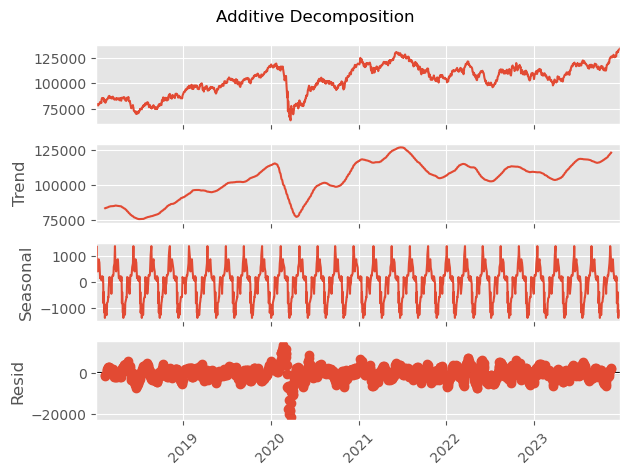

In [5]:
# Additive Decomposition

zo.seasonal_decomposition(kind = 'multiplicative')

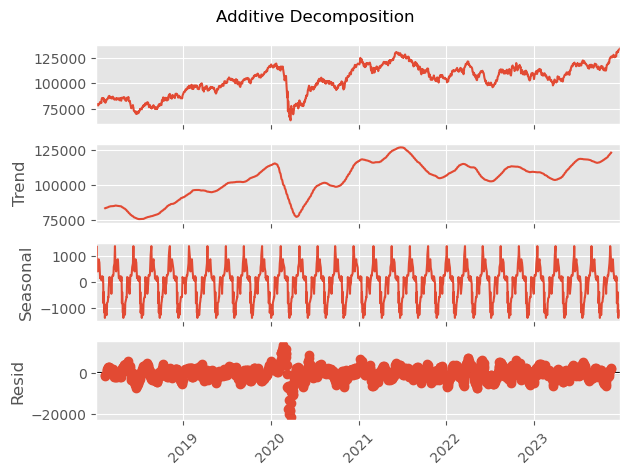

In [6]:
# Multiplicative Decomposition

zo.seasonal_decomposition(kind = 'multiplicative')

- Trend

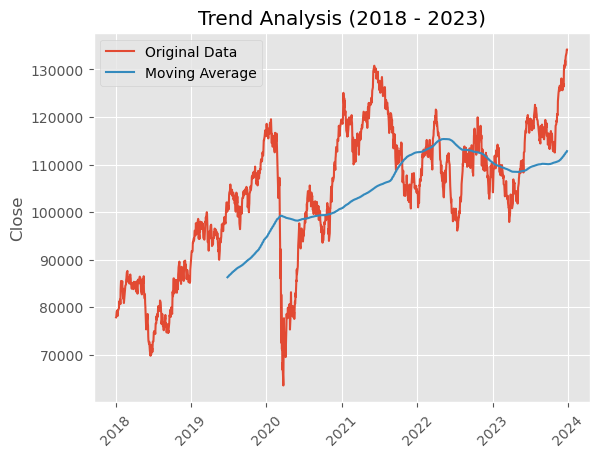

In [7]:
zo.trend(365)

- Periodogram

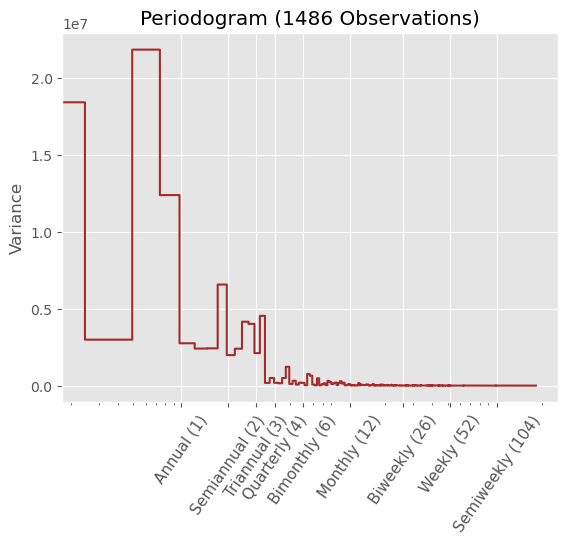

In [8]:
zo.periodogram()

- Seasonal Plots

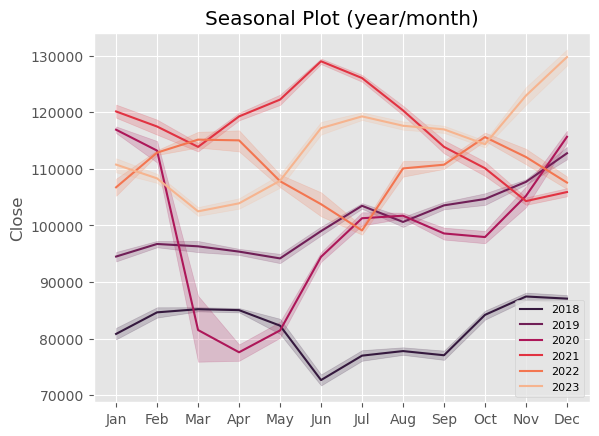

In [9]:
# Monthly analysis

zo.seasonal_plots('year', 'month', x_label = 'hide')

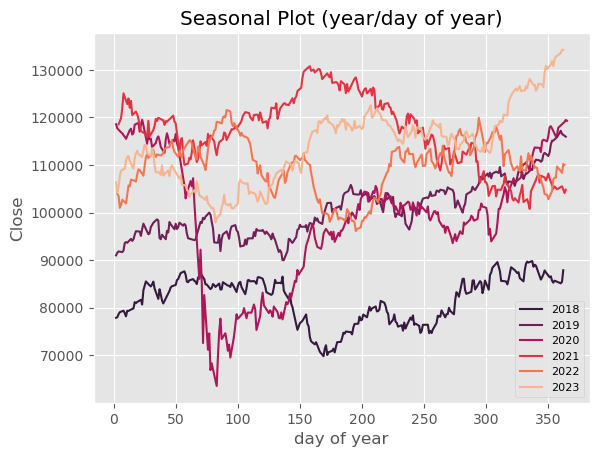

In [10]:
# Daily analysis

zo.seasonal_plots('year', 'day of year')

- Lag Plots

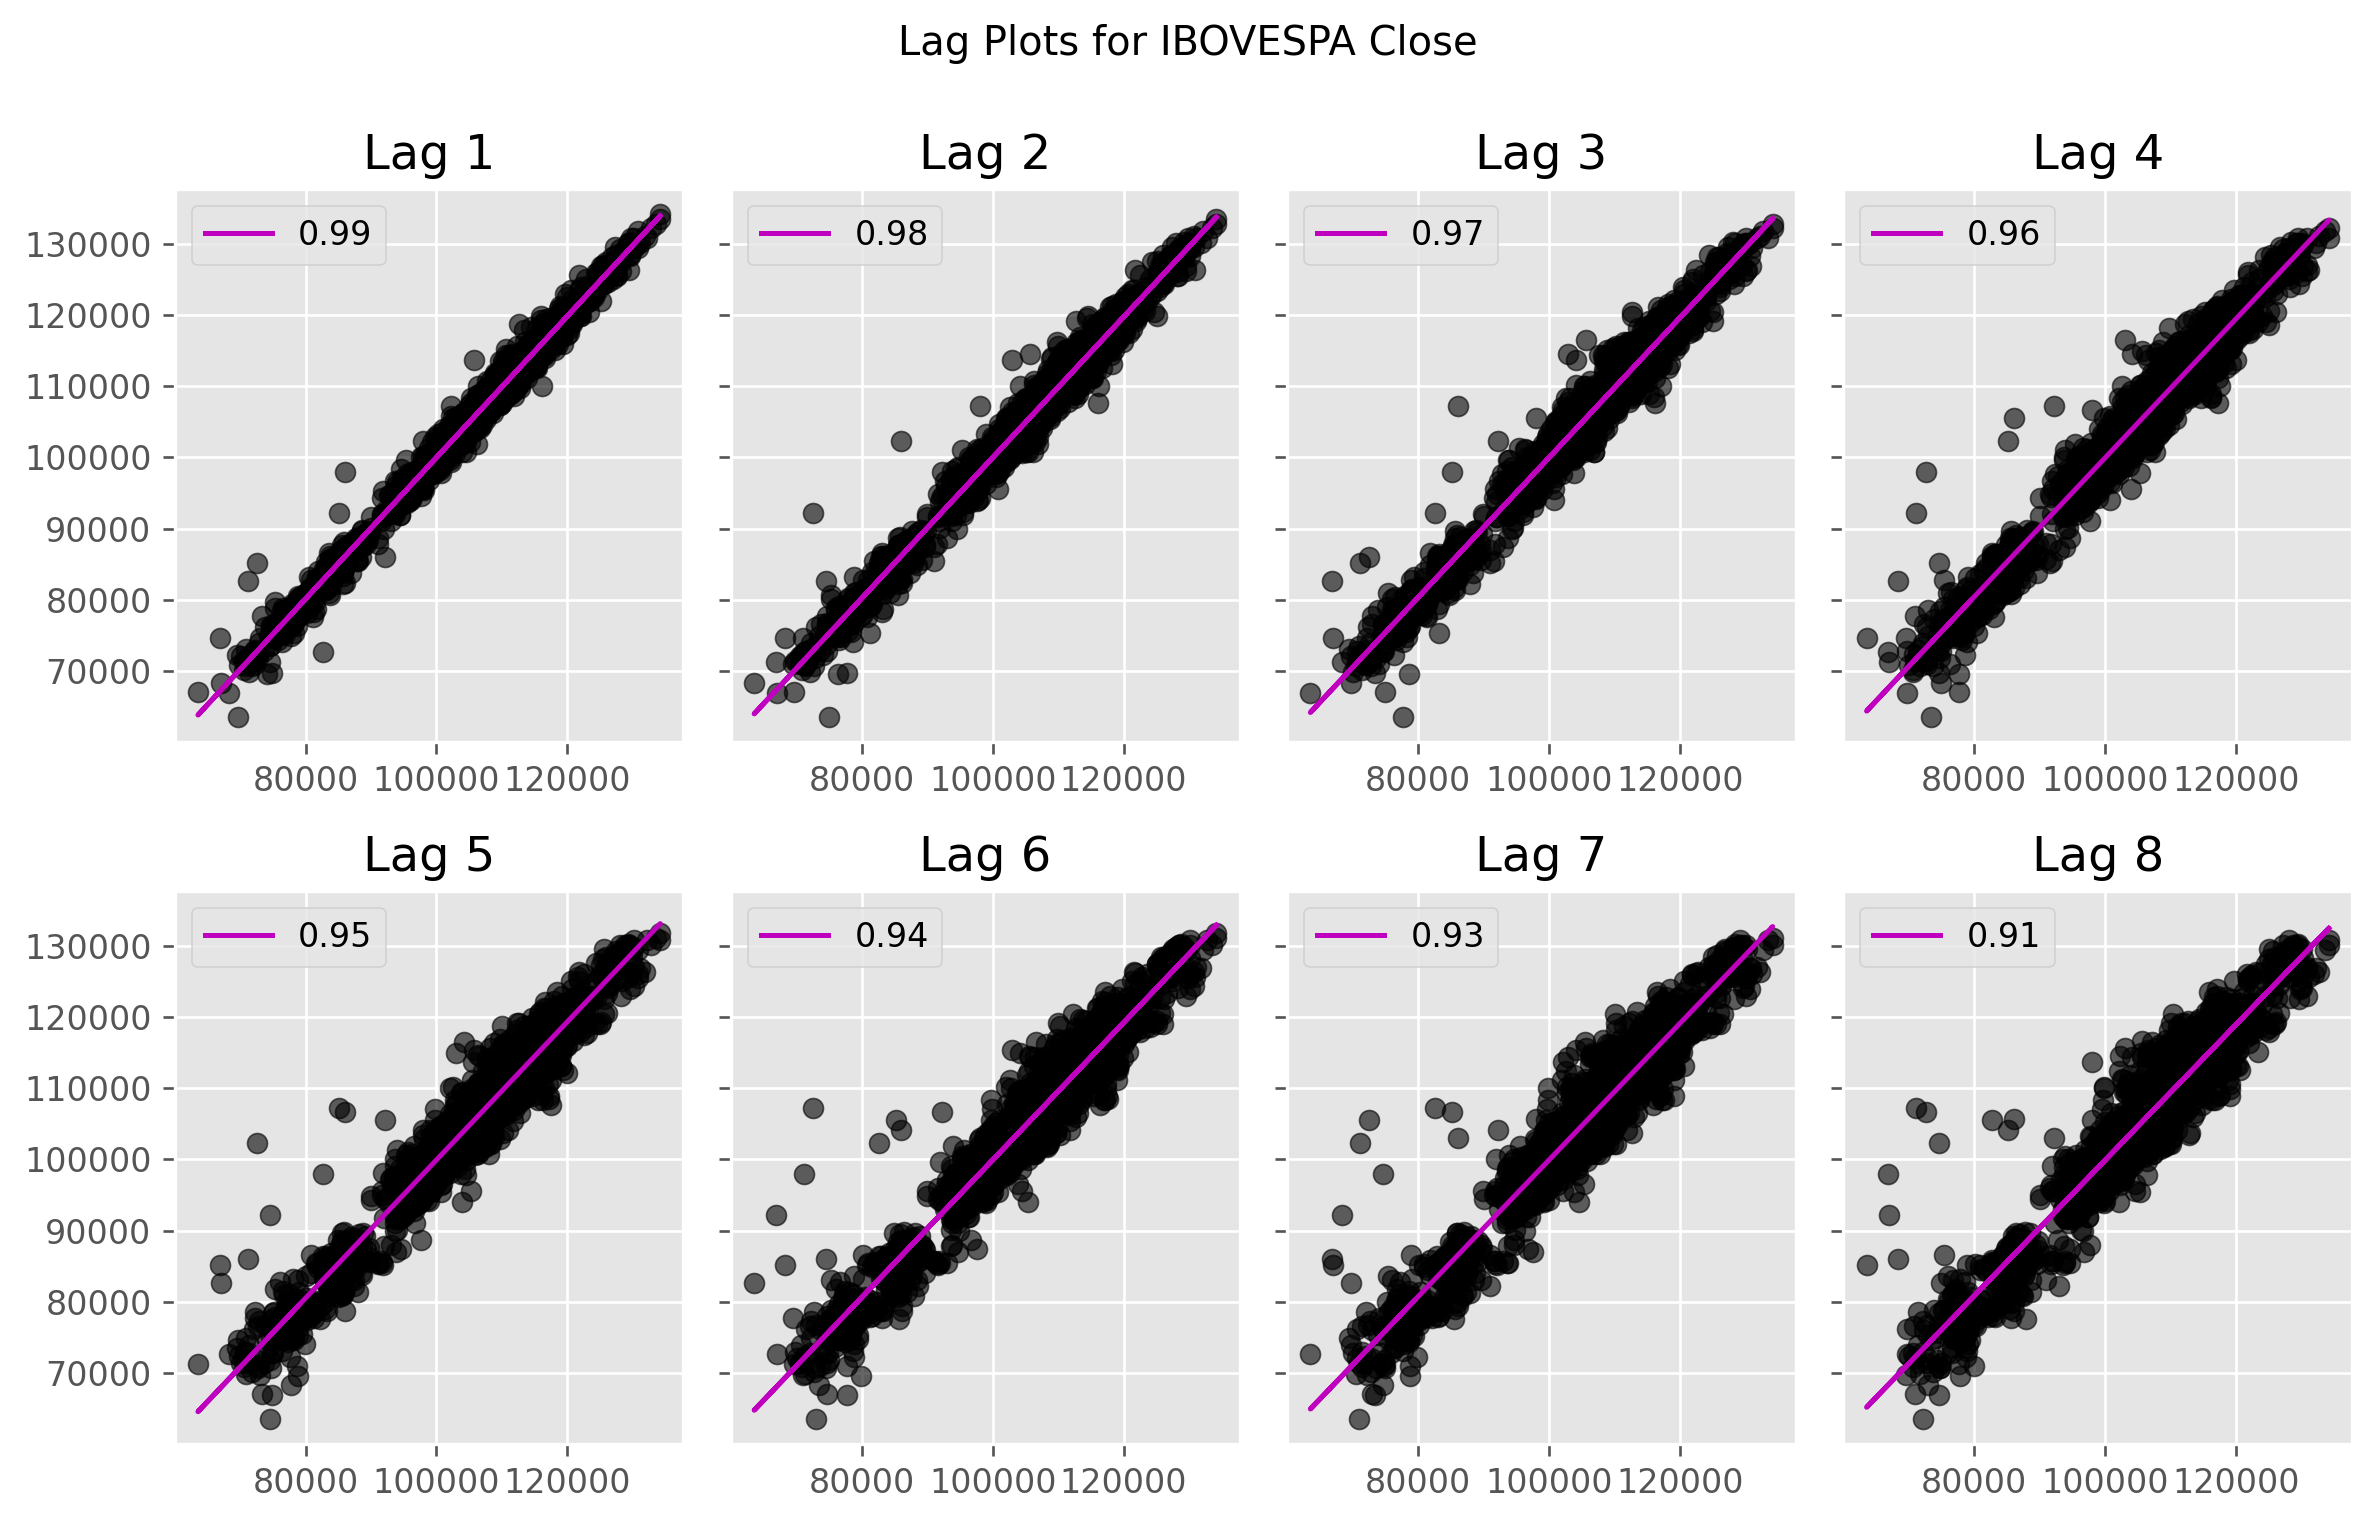

In [11]:
# Lag plots for six lags

zo.lags(8, 'Lag Plots for IBOVESPA Close')

- Augmented Dickey-Fuller Test

In [12]:
# Logarithmic transformation, differencing and Aumented Dickey-Fuller Test

log_data = np.log(zo.data)
diff_data = log_data.diff().dropna()
zt_diff = zp.Zeit(diff_data)
zt_diff.adfuller_test()

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.193742e+01
p-value,4.627291e-22
Lags Used,7.000000e+00
Observations,1.477000e+03
Critical Value (1%),-3.434785e+00
Critical Value (5%),-2.863499e+00
Critical Value (10%),-2.567813e+00


- Split Data

In [13]:
# Testing in an alternative dataset

retail_sales_path = 'retail_sales_us.csv'
df = pd.read_csv(retail_sales_path)
df.head()

,Date,Water_UnitSales,Alcohol_UnitSales
0,10/6/2019,166396556.0,150101757.0
1,10/13/2019,157116476.0,147027893.0
2,10/20/2019,150442968.0,145748467.0
3,10/27/2019,149196153.0,145996632.0
4,11/3/2019,144728816.0,146590953.0


In [14]:
# Logarithmic transformation, differencing and Aumented Dickey-Fuller Test

zo = zp.Zeit(retail_sales_path, '%m/%d/%Y', 'Date', 'Alcohol_UnitSales')
log_data = np.log(zo.data)
diff_data = log_data.diff().dropna()
zt_diff = zp.Zeit(diff_data)
zt_diff.adfuller_test()

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.250978e+01
p-value,2.690310e-23
Lags Used,2.000000e+00
Observations,1.840000e+02
Critical Value (1%),-3.466398e+00
Critical Value (5%),-2.877380e+00
Critical Value (10%),-2.575214e+00


In [15]:
# Splitting data for forecasting

train_data, test_data = zo.split_data() # Original scale
train_data_diff, test_data_diff = zt_diff.split_data() # Data Differenced in log scale
train_data.data.size, test_data.data.size

(150, 38)

- Correlogram

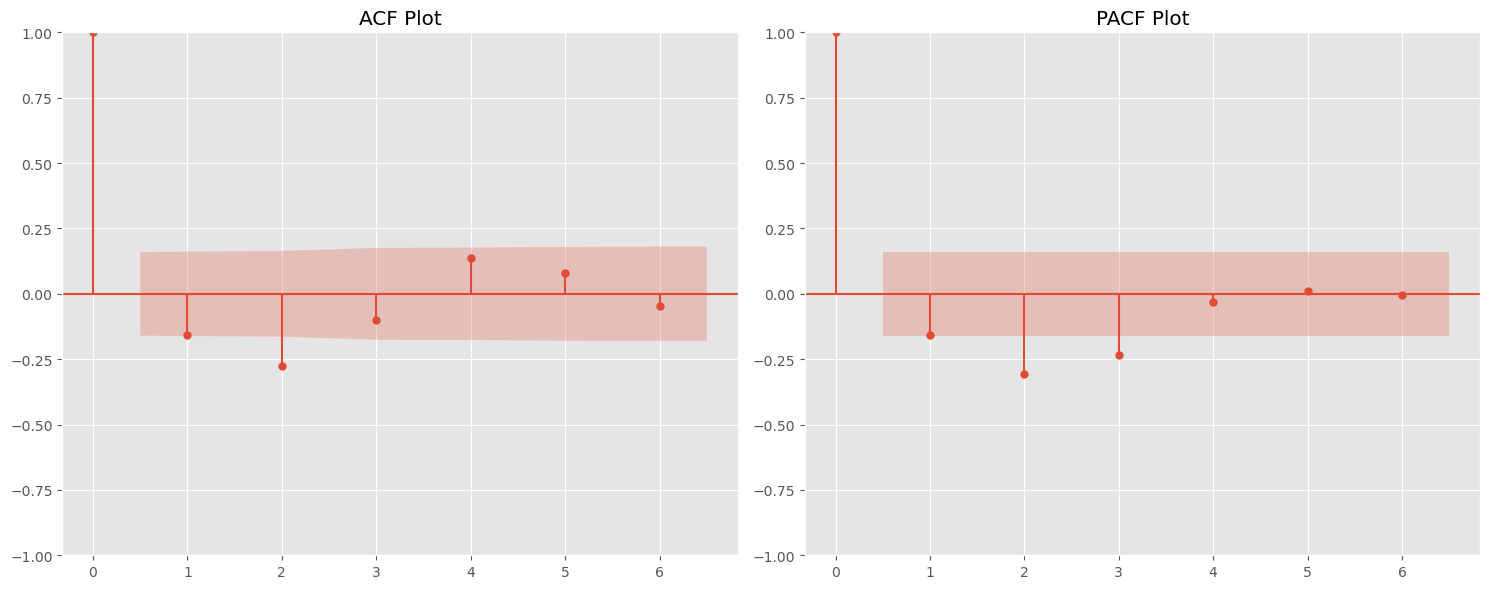

In [16]:
# Displaying correlograms

train_data_diff.correlogram()

- Evaluate

In [17]:
# Forecast for the next 23 weeks

steps_diff = len(test_data_diff.data) + 23
steps_diff

60

In [18]:
# Fitting the data with Exponential Smothing (TES) model

tes_model = ES(train_data.data, trend = 'add', damped_trend = True, seasonal = 'add', seasonal_periods = 52).fit()

In [19]:
# Forecasting with TES for the next 'steps_' weeks

steps_ = steps_diff + 1
tes_forecast = tes_model.forecast(steps_).iloc[1:]

In [20]:
# List of candidate models (Exponential smoothing only)

tes = tes_forecast.iloc[:-23]
forecast_models_list = [('TES', tes)]

In [21]:
# Setting the initial data point of the test set to be equal to the forecasted  

if test_data.data.index[0] == test_data_diff.data.index[0]:
    eval_data = test_data.data  
else:
    eval_data = test_data.data.iloc[1:]  

In [22]:
# Comparison

zo.evaluate(forecast_models_list, eval_data)

,2022-08-28,2022-09-04,2022-09-11,2022-09-18,2022-09-25,2022-10-02,2022-10-09,2022-10-16,2022-10-23,2022-10-30
Actual,1.557263e+08,1.654902e+08,1.545241e+08,1.538235e+08,1.544509e+08,1.513215e+08,1.515360e+08,1.506181e+08,1.474300e+08,1.502449e+08
TES,1.558970e+08,1.644032e+08,1.528659e+08,1.520253e+08,1.506519e+08,1.504586e+08,1.501845e+08,1.488980e+08,1.480109e+08,1.514673e+08


In [23]:
# Metrics

zo.evaluate(forecast_models_list, eval_data, 'metrics')

,MSE,RMSE,MAE,MAPE
TES,3.281246e+13,5.728217e+06,4.242597e+06,0.028922


# END